#第4章 画像分類
##第4.3節 Transformerによる手法～Vision Transformerを実装してみよう

###モジュールのインポートとGoogleドライブのマウント

In [ ]:
from collections import deque
import copy
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as T

# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/4_classification/4_3_transformer')

import util
import eval

###マルチヘッドアテンションを使った自己アテンションの実装

In [ ]:
class SelfAttention(nn.Module):
    '''
    自己アテンション
    dim_hidden: 入力特徴量の次元
    num_heads : マルチヘッドアテンションのヘッド数
    qkv_bias  : クエリなどを生成する全結合層のバイアスの有無
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 qkv_bias: bool=False):
        super().__init__()

        # 特徴量を各ヘッドのために分割するので、
        # 特徴量次元をヘッド数で割り切れるか検証
        assert dim_hidden % num_heads == 0

        self.num_heads = num_heads

        # ヘッド毎の特徴量次元
        dim_head = dim_hidden // num_heads

        # ソフトマックスのスケール値
        self.scale = dim_head ** -0.5

        # ヘッド毎にクエリ、キーおよびバリューを生成するための全結合層
        self.proj_in = nn.Linear(
            dim_hidden, dim_hidden * 3, bias=qkv_bias)

        # 各ヘッドから得られた特徴量を一つにまとめる全結合層
        self.proj_out = nn.Linear(dim_hidden, dim_hidden)

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor):        
        bs, ns = x.shape[:2]

        qkv = self.proj_in(x)

        # view関数により
        # [バッチサイズ, 特徴量数, QKV, ヘッド数, ヘッドの特徴量次元]
        # permute関数により
        # [QKV, バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        qkv = qkv.view(
            bs, ns, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)

        # クエリ、キーおよびバリューに分解
        q, k, v = qkv.unbind(0)

        # クエリとキーの行列積とアテンションの計算(今回マスクは不使用)
        # attnは[バッチサイズ, ヘッド数, 特徴量数, 特徴量数]
        attn = q.matmul(k.transpose(-2, -1))
        attn = (attn * self.scale).softmax(dim=-1)

        # アテンションとバリューの行列積によりバリューを収集
        # xは[バッチサイズ, ヘッド数, 特徴量数, ヘッドの特徴量次元]
        x = attn.matmul(v)

        # permute関数により
        # [バッチサイズ, 特徴量数, ヘッド数, ヘッドの特徴量次元]
        # flatten関数により全てのヘッドから得られる特徴量を連結して、
        # [バッチサイズ, 特徴量数, ヘッド数 * ヘッドの特徴量次元]
        x = x.permute(0, 2, 1, 3).flatten(2)
        x = self.proj_out(x)

        return x


###Transformerエンコーダ内のFNNの実装

In [ ]:
class FNN(nn.Module):
    '''
    Transformerエンコーダ内の順伝播型ニューラルネットワーク
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, dim_feedforward: int):
        super().__init__()

        self.linear1 = nn.Linear(dim_hidden, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, dim_hidden)
        self.activation = nn.GELU()

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)

        return x

###Transformerエンコーダ層の実装

In [ ]:
class TransformerEncoderLayer(nn.Module):
    '''
    Transformerエンコーダ層
    dim_hidden     : 入力特徴量の次元
    num_heads      : ヘッド数
    dim_feedforward: 中間特徴量の次元
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int):
        super().__init__()

        self.attention = SelfAttention(dim_hidden, num_heads)
        self.fnn = FNN(dim_hidden, dim_feedforward)

        self.norm1 = nn.LayerNorm(dim_hidden)
        self.norm2 = nn.LayerNorm(dim_hidden)

    '''
    順伝播関数
    x: 入力特徴量, [バッチサイズ, 特徴量数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor):
        x = self.norm1(x)
        x = self.attention(x) + x
        x = self.norm2(x)
        x = self.fnn(x) + x

        return x

###Vision Transformerの実装

In [ ]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer
    num_classes    : 分類対象の物体クラス数
    img_size       : 入力画像の大きさ(幅と高さ等しいことを想定)
    patch_size     : パッチの大きさ(幅と高さ等しいことを想定)
    dim_hidden     : 入力特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    dim_feedforward: FNNにおける中間特徴量の次元
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, num_classes: int, img_size: int,
                 patch_size: int, dim_hidden: int, num_heads: int,
                 dim_feedforward: int, num_layers: int):
        super().__init__()

        # 画像をパッチに分解するために、
        # 画像の大きさがパッチの大きさで割り切れるか確認
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.patch_size = patch_size

        # パッチの行数と列数はともにimg_size // patch_sizeであり、
        # パッチ数はその2乗になる
        num_patches = (img_size // patch_size) ** 2

        # パッチ特徴量はパッチを平坦化することにより生成されるため、
        # その次元はpatch_size * patch_size * 3 (RGBチャネル)
        dim_patch = 3 * patch_size ** 2

        # パッチ特徴量をTransformerエンコーダに入力する前に
        # パッチ特徴量の次元を変換する全結合層
        self.patch_embed = nn.Linear(dim_patch, dim_hidden)

        # 位置埋め込み(パッチ数 + クラス埋め込みの分を用意)
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, dim_hidden))

        # クラス埋め込み
        self.class_token = nn.Parameter(
            torch.zeros((1, 1, dim_hidden)))

        # Transformerエンコーダ層
        self.layers = nn.ModuleList([TransformerEncoderLayer(
            dim_hidden, num_heads, dim_feedforward
        ) for _ in range(num_layers)])

        # ロジットを生成する前のレイヤー正規化と全結合
        self.norm = nn.LayerNorm(dim_hidden)
        self.linear = nn.Linear(dim_hidden, num_classes)

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, x: torch.Tensor, return_embed: bool=False):
        bs, c, h, w = x.shape

        # 入力画像の大きさがクラス生成時に指定したimg_sizeと
        # 合致しているか確認
        assert h == self.img_size and w == self.img_size

        # 高さ軸と幅軸をそれぞれパッチ数 * パッチの大きさに分解し、
        # [バッチサイズ, チャネル数, パッチの行数, パッチの大きさ,
        #                            パッチの列数, パッチの大きさ]
        # の形にする
        x = x.view(bs, c, h // self.patch_size, self.patch_size,
                   w // self.patch_size, self.patch_size)

        # permute関数により
        # [バッチサイズ, パッチ行数, パッチ列数, チャネル,
        #                パッチの大きさ, パッチの大きさ]
        # の形にする
        x = x.permute(0, 2, 4, 1, 3, 5)

        # パッチを平坦化
        # permute関数適用後にはメモリ上のデータ配置の整合性の関係で
        # view関数を使えないのでreshape関数を使用
        x = x.reshape(
            bs, (h // self.patch_size) * (w // self.patch_size), -1)

        x = self.patch_embed(x)

        # クラス埋め込みをバッチサイズ分用意
        class_token = self.class_token.expand(bs, -1, -1)

        x = torch.cat((class_token, x), dim=1)

        x += self.pos_embed

        # Transformerエンコーダ層を適用
        for layer in self.layers:
            x = layer(x)

        # クラス埋め込みをベースとしたの特徴量を抽出
        x = x[:, 0]

        x = self.norm(x)

        if return_embed:
            return x

        x = self.linear(x)

        return x

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.linear.weight.device

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        return copy.deepcopy(self)

###学習・評価におけるハイパーパラメータやオプションの設定

In [ ]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.2
        # パッチサイズ
        self.patch_size = 4
        # 隠れ層の次元
        self.dim_hidden = 512
        # マルチヘッドアテンションのヘッド数
        self.num_heads = 8
        # Transformerエンコーダ層内のFNNにおける隠れ層の特徴量次元
        self.dim_feedforward = 512
        # Transformerエンコーダの層数
        self.num_layers = 6
        # 学習エポック数
        self.num_epochs = 30
        # 検証する学習率
        self.lr = 1e-2
        # 移動平均で計算する損失と正確度の値の数
        self.moving_avg = 20
        # バッチサイズ
        self.batch_size = 32
        # データローダーに使うCPUプロセスの数
        self.num_workers = 2
        # 学習に使うデバイス
        self.device = 'cuda'
        # t-SNEでプロットするサンプル数
        self.num_samples = 200

###学習・評価を行う関数

In [ ]:
def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各チャネルの平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=T.ToTensor())
    channel_mean, channel_std = util.get_dataset_statistics(dataset)

    # 画像の整形を行うクラスのインスタンスを用意
    transforms = T.Compose((
        T.ToTensor(),
        T.Normalize(mean=channel_mean, std=channel_std),
    ))

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=transforms)
    test_dataset = torchvision.datasets.CIFAR10(
        root='data', train=False, download=True,
        transform=transforms)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers)
    
    # 目的関数の生成
    loss_func = F.cross_entropy

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None
    
    # Vision Transformerモデルの生成
    model = VisionTransformer(
        len(train_dataset.classes), 32, config.patch_size,
        config.dim_hidden, config.num_heads, config.dim_feedforward,
        config.num_layers)

    # モデルを指定デバイスに転送(デフォルトはGPU)
    model.to(config.device)

    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

    for epoch in range(config.num_epochs):
        model.train()
            
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(model.get_device())
                y = y.to(model.get_device())
                    
                # パラメータの勾配をリセット
                optimizer.zero_grad()

                # 順伝播
                y_pred = model(x)

                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == \
                            y).float().mean()

                # 誤差逆伝播
                loss.backward()

                # パラメータの更新
                optimizer.step()

                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()})

        # 検証セットを使って精度評価
        val_loss, val_accuracy = eval.evaluate(
            val_loader, model, loss_func)
        print(f'検証　: loss = {val_loss:.3f}, '
                f'accuracy = {val_accuracy:.3f}')

        # より良い検証結果が得られた場合、モデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()

    # テスト
    test_loss, test_accuracy = eval.evaluate(
        test_loader, model_best, loss_func)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')
    
    # t-SNEを使って特徴量の分布をプロット
    util.plot_t_sne(test_loader, model_best, config.num_samples)

###学習・評価の実行

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


[エポック 1]: 100%|██████████| 1250/1250 [01:02<00:00, 20.05it/s, loss=1.66, accuracy=0.373]


検証　: loss = 1.756, accuracy = 0.343


[エポック 2]: 100%|██████████| 1250/1250 [01:02<00:00, 20.03it/s, loss=1.56, accuracy=0.433]


検証　: loss = 1.616, accuracy = 0.417


[エポック 3]: 100%|██████████| 1250/1250 [01:02<00:00, 19.98it/s, loss=1.39, accuracy=0.466]


検証　: loss = 1.441, accuracy = 0.481


[エポック 4]: 100%|██████████| 1250/1250 [01:01<00:00, 20.20it/s, loss=1.37, accuracy=0.497]


検証　: loss = 1.341, accuracy = 0.517


[エポック 5]: 100%|██████████| 1250/1250 [01:02<00:00, 20.07it/s, loss=1.15, accuracy=0.567]


検証　: loss = 1.235, accuracy = 0.561


[エポック 6]: 100%|██████████| 1250/1250 [01:02<00:00, 20.11it/s, loss=1.16, accuracy=0.575]


検証　: loss = 1.202, accuracy = 0.567


[エポック 7]: 100%|██████████| 1250/1250 [01:02<00:00, 19.85it/s, loss=1.17, accuracy=0.575]


検証　: loss = 1.172, accuracy = 0.578


[エポック 8]: 100%|██████████| 1250/1250 [01:02<00:00, 20.07it/s, loss=1.02, accuracy=0.647]


検証　: loss = 1.113, accuracy = 0.608


[エポック 9]: 100%|██████████| 1250/1250 [01:02<00:00, 20.07it/s, loss=1.05, accuracy=0.652]


検証　: loss = 1.143, accuracy = 0.588


[エポック 10]: 100%|██████████| 1250/1250 [01:02<00:00, 20.08it/s, loss=0.953, accuracy=0.648]


検証　: loss = 1.054, accuracy = 0.626


[エポック 11]: 100%|██████████| 1250/1250 [01:03<00:00, 19.80it/s, loss=0.819, accuracy=0.684]


検証　: loss = 1.127, accuracy = 0.611


[エポック 12]: 100%|██████████| 1250/1250 [01:02<00:00, 20.08it/s, loss=0.974, accuracy=0.655]


検証　: loss = 1.064, accuracy = 0.632


[エポック 13]: 100%|██████████| 1250/1250 [01:02<00:00, 20.08it/s, loss=0.846, accuracy=0.709]


検証　: loss = 1.024, accuracy = 0.640


[エポック 14]: 100%|██████████| 1250/1250 [01:02<00:00, 20.12it/s, loss=0.782, accuracy=0.706]


検証　: loss = 1.104, accuracy = 0.619


[エポック 15]: 100%|██████████| 1250/1250 [01:02<00:00, 19.89it/s, loss=0.651, accuracy=0.772]


検証　: loss = 1.031, accuracy = 0.650


[エポック 16]: 100%|██████████| 1250/1250 [01:02<00:00, 20.06it/s, loss=0.599, accuracy=0.792]


検証　: loss = 1.092, accuracy = 0.642


[エポック 17]: 100%|██████████| 1250/1250 [01:02<00:00, 20.11it/s, loss=0.59, accuracy=0.797]


検証　: loss = 1.055, accuracy = 0.657


[エポック 18]: 100%|██████████| 1250/1250 [01:02<00:00, 20.07it/s, loss=0.549, accuracy=0.809]


検証　: loss = 1.102, accuracy = 0.656


[エポック 19]: 100%|██████████| 1250/1250 [01:02<00:00, 20.04it/s, loss=0.478, accuracy=0.828]


検証　: loss = 1.127, accuracy = 0.656


[エポック 20]: 100%|██████████| 1250/1250 [01:02<00:00, 19.99it/s, loss=0.476, accuracy=0.834]


検証　: loss = 1.211, accuracy = 0.652


[エポック 21]: 100%|██████████| 1250/1250 [01:01<00:00, 20.25it/s, loss=0.343, accuracy=0.881]


検証　: loss = 1.345, accuracy = 0.634


[エポック 22]: 100%|██████████| 1250/1250 [01:02<00:00, 20.05it/s, loss=0.323, accuracy=0.883]


検証　: loss = 1.350, accuracy = 0.649


[エポック 23]: 100%|██████████| 1250/1250 [01:01<00:00, 20.20it/s, loss=0.225, accuracy=0.914]


検証　: loss = 1.508, accuracy = 0.630


[エポック 24]: 100%|██████████| 1250/1250 [01:01<00:00, 20.28it/s, loss=0.272, accuracy=0.903]


検証　: loss = 1.534, accuracy = 0.645


[エポック 25]: 100%|██████████| 1250/1250 [01:01<00:00, 20.22it/s, loss=0.166, accuracy=0.939]


検証　: loss = 1.684, accuracy = 0.638


[エポック 26]: 100%|██████████| 1250/1250 [01:02<00:00, 20.08it/s, loss=0.127, accuracy=0.961]


検証　: loss = 1.697, accuracy = 0.653


[エポック 27]: 100%|██████████| 1250/1250 [01:02<00:00, 20.15it/s, loss=0.0681, accuracy=0.98]


検証　: loss = 1.766, accuracy = 0.651


[エポック 28]: 100%|██████████| 1250/1250 [01:02<00:00, 20.15it/s, loss=0.0504, accuracy=0.983]


検証　: loss = 1.935, accuracy = 0.647


[エポック 29]: 100%|██████████| 1250/1250 [01:01<00:00, 20.20it/s, loss=0.0061, accuracy=0.998]


検証　: loss = 1.863, accuracy = 0.664


[エポック 30]: 100%|██████████| 1250/1250 [01:01<00:00, 20.24it/s, loss=0.00313, accuracy=1]


検証　: loss = 1.920, accuracy = 0.668
テスト: loss = 1.042, accuracy = 0.639


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


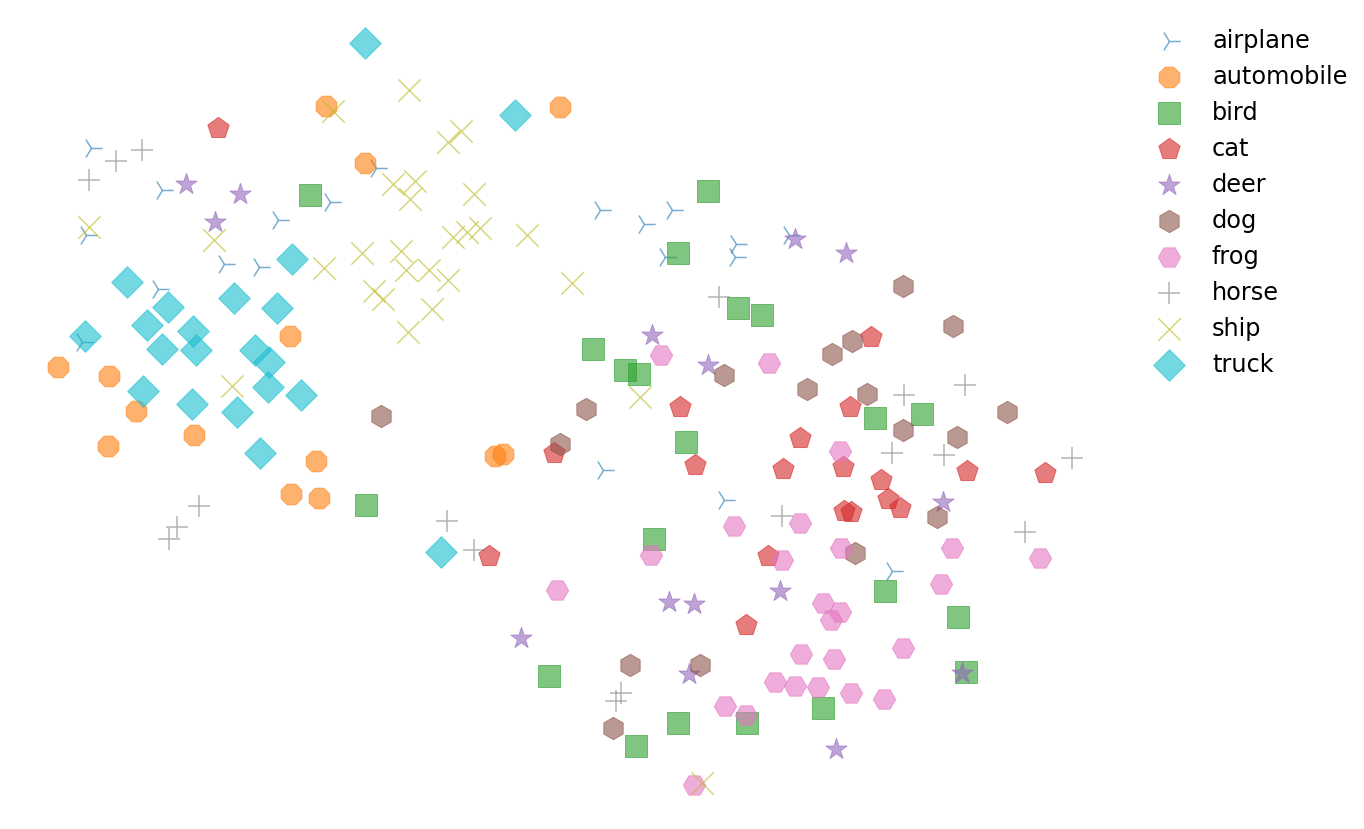

In [ ]:
train_eval()